In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms.v2 as T
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
from lpips import LPIPS

In [3]:
make_pil = T.ToPILImage()

train_data = torchvision.datasets.ImageFolder(
    "data/resized/train",
    transform=T.Compose([
        # T.Resize((64, 64)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
)
val_data = torchvision.datasets.ImageFolder(
    "data/resized/test",
    transform=T.Compose([
        # T.Resize((64, 64)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=4, persistent_workers=True, prefetch_factor=32)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=False, num_workers=4, persistent_workers=True)

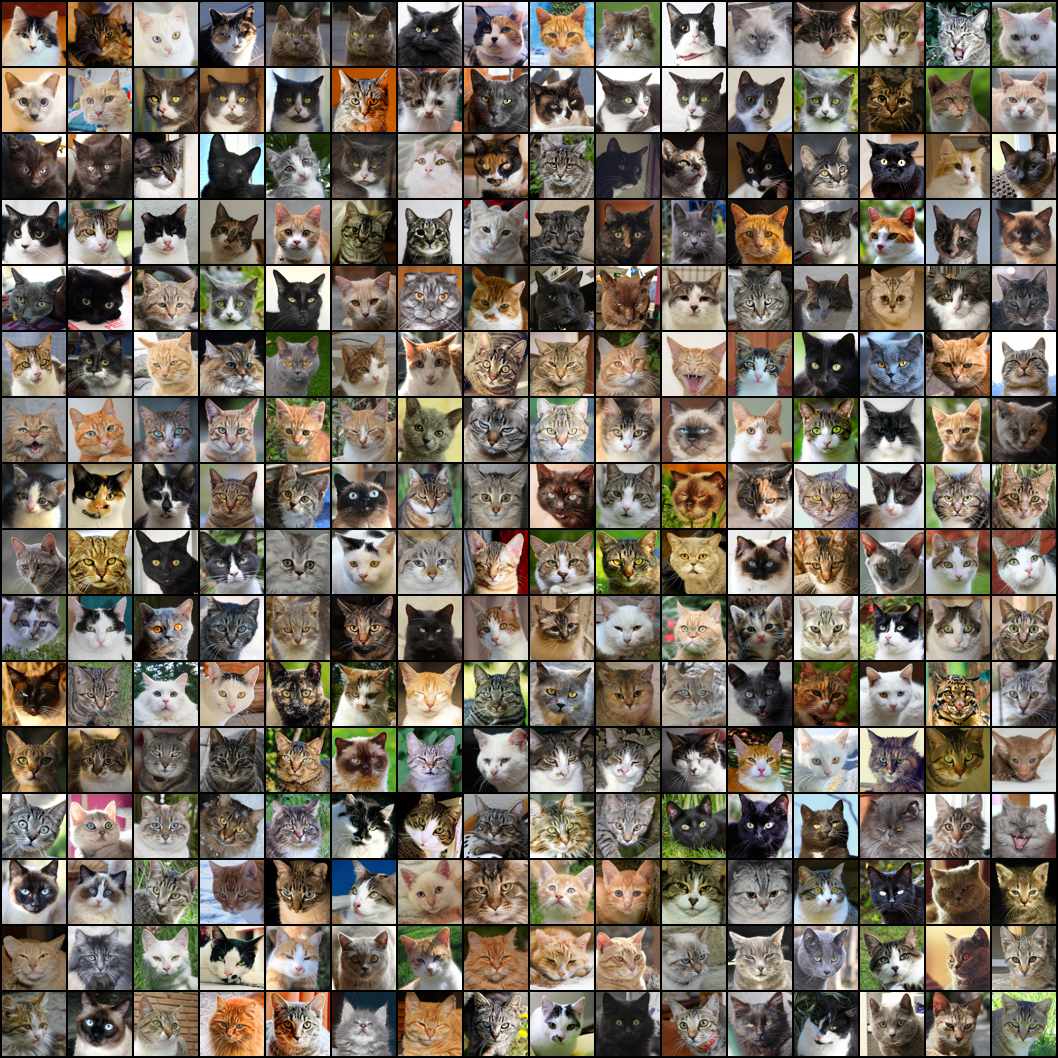

In [4]:
x, _ = next(iter(val_loader))
make_pil(torchvision.utils.make_grid(x, nrow=16))

In [12]:
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, m=4):
        super().__init__()
        self.norm1 = nn.GroupNorm(in_channels, in_channels)
        self.norm2 = nn.GroupNorm(out_channels, out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        
        self.skip = nn.Conv2d(in_channels, out_channels, 1)
        
    def forward(self, x):
        residual = x
        
        x = self.norm1(x)
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.norm2(x)
        x = self.conv2(x)
        x = F.gelu(x)
        
        return x + self.skip(residual)

class AttnBlock(nn.Module):
    def __init__(self, in_channels, num_heads):
        super().__init__()
        self.in_channels = in_channels

        self.attn = nn.MultiheadAttention(in_channels, num_heads, dropout=0, add_bias_kv=False, batch_first=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, W, H = x.shape
        x = rearrange(x, "b c h w -> b (h w) c")
        x = x + self.attn(x, x, x, need_weights=False)[0]
        x = rearrange(x, "b (h w) c -> b c h w", b=B, c=C, w=W, h=H)
        return x

class DiagonalGaussian(nn.Module):
    def __init__(self, sample: bool = True, chunk_dim: int = 1):
        super().__init__()
        self.sample = sample
        self.chunk_dim = chunk_dim

    def forward(self, mean, logvar) -> torch.Tensor:
        if self.sample:
            std = torch.exp(0.5 * logvar)
            return mean + std * torch.randn_like(mean)
        else:
            return mean

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Residual(3, 16),
            nn.MaxPool2d(2),
            Residual(16, 32),
            nn.MaxPool2d(2),
            Residual(32, 64),
            Residual(64, 64),
            Residual(64, 64),
            nn.MaxPool2d(2),
            # AttnBlock(64, 16),
            # AttnBlock(64, 16),
            Residual(64, 8 * 2),
        )
        
        self.decoder = nn.Sequential(
            Residual(8, 64),
            # AttnBlock(64, 16),
            # AttnBlock(64, 16),
            nn.Upsample(scale_factor=2),
            Residual(64, 64),
            Residual(64, 64),
            Residual(64, 32),
            nn.Upsample(scale_factor=2),
            Residual(32, 16),
            nn.Upsample(scale_factor=2),
            Residual(16, 3),
            nn.Conv2d(3, 3, 3, padding=1),
            nn.Conv2d(3, 3, 3, padding=1, groups=3)
            nn.Sigmoid(),
        )
        self.reg = DiagonalGaussian()
        
    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    @staticmethod
    def kl_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        z = self.reg(mu, logvar)
        
        x = self.decoder(z)
        return x, mu, logvar
    
model = Model()
print(summary(model, (64, 3, 64, 64), depth=2))
# model = torch.jit.script(model)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1793034134.py, line 82)

In [13]:
model.to("cuda")
lpips = LPIPS("squeeze")
lpips.to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=5e-4)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_pa

In [14]:
for epoch in range(20):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for x, _ in pbar:
        optimizer.zero_grad()
        x = x.to("cuda")
        x_hat, mu, logvar = model(x)
        recon_loss = F.binary_cross_entropy(x_hat, x)
        kl = Model.kl_loss(mu, logvar).mean() / x.shape.numel()
        lpips_loss = lpips(2 * x - 1, 2 * x_hat - 1).mean() * 1e-3
        
        loss = recon_loss + kl + lpips_loss

        loss.backward()
        optimizer.step()
        pbar.set_postfix_str(f"loss={loss.item():.4f}, psnr={10 * torch.log10(1 / F.mse_loss(x, x_hat)).item():.4f}, recon_loss={recon_loss:.4f}, kl={kl:.4f}, lpips_loss={lpips_loss:.4f}")
        
    model.eval()
    total_loss = 0
    total_psnr = 0
    
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to("cuda")
            x_hat, mu, logvar = model(x)
            recon_loss = F.binary_cross_entropy(x_hat, x)
            kl = Model.kl_loss(mu, logvar).mean() / x.shape.numel()
            lpips_loss = lpips(2 * x - 1, 2 * x_hat - 1).mean() * 1e-3
        
            loss = recon_loss + kl + lpips_loss

            total_loss += loss.item()
            total_psnr += 10 * torch.log10(1 / F.mse_loss(x, x_hat)).item()
            
    total_loss /= len(val_loader)
    total_psnr /= len(val_loader)    

Epoch 4:  80%|████████  | 45/56 [00:09<00:02,  4.86it/s, loss=0.6036, psnr=18.2482, recon_loss=0.5920, kl=0.0111, lpips_loss=0.0005]


KeyboardInterrupt: 

In [ ]:
# reconstruct images
model.eval()
x, _ = next(iter(val_loader))
x = x.to("cuda")[:128]
x_hat, mu, logvar = model(x)
x_hat = x_hat.to("cpu").detach()
x = x.to("cpu")
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(x, nrow=8).permute(1, 2, 0), interpolation="nearest")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(torchvision.utils.make_grid(x_hat, nrow=8).permute(1, 2, 0), interpolation="nearest")
plt.axis("off")
plt.title("Reconstructed")
plt.show()

In [ ]:
make_pil(torchvision.utils.make_grid(model.decoder(torch.randn_like(mu, device="cuda")), nrow=16))